import data

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
 
train = pd.read_csv('used_car_train_20200313.csv', sep = ' ')
test = pd.read_csv('used_car_testA_20200313.csv', sep = ' ')

detect outliers

1. delete

2. use mean or median to update

3. see outliers as missing data

In [3]:
def outliers_proc(data, col_name, scale = 3):
    """
    清晰pandas表格中某一列中的异常值，默认用 box_plot（scale=3）进行清洗
    data: 接收pandas表格
    col_name: pandas表格的列名
    scale: 尺度，用来划定数据的上限与下限的
    返回值是处理好的数据
    """
    
    def box_plot_outliers(data_ser, box_scale):
        """
        利用箱线图去除异常值
        data_ser: pandas序列
        param box_scale: 箱型图划定上下限的尺度
        返回值分两部分，第一部分是异常值的位置（用序列表示），第二部分是上下限的具体值
        """
        
        iqr = box_scale * (data_ser.quantile(0.75) - data_ser.quantile(0.25))
        
        # 计算有效数据的下限和上限
        val_low = data_ser.quantile(0.25) - iqr
        val_up = data_ser.quantile(0.75) + iqr
        
        rule_low = (data_ser < val_low)
        rule_up = (data_ser > val_up)
        
        return (rule_low, rule_up), (val_low, val_up)
 
    data_n = data.copy()
    data_series = data_n[col_name]
    rule, value = box_plot_outliers(data_series, box_scale = scale)
    # 从原序列汇总提取出所有异常值
    # 生成记录异常值索引的数组
    index = np.arange(data_series.shape[0])[rule[0] | rule[1]]
    print("Delete number is: {}".format(len(index)))
    # 根据索引在原数据中删除对应的行
    data_n = data_n.drop(index)
    # 重置数据的索引
    data_n.reset_index(drop = True, inplace = True)
    print("Now row number is: {}".format(data_n.shape[0]))
    
    # 输出小于下限和大于上限的异常值的统计数据
    index_low = np.arange(data_series.shape[0])[rule[0]]
    outliers = data_series.iloc[index_low]
    print("Description of data less than the lower bound is:")
    print(pd.Series(outliers).describe())
    
    index_up = np.arange(data_series.shape[0])[rule[1]]
    outliers = data_series.iloc[index_up]
    print("Description of data larger than the upper bound is:")
    print(pd.Series(outliers).describe())
    
    # 绘制处理前和处理后的箱型图
    fig, ax = plt.subplots(1, 2, figsize=(10, 7))
    sns.boxplot(y = data[col_name], data = data, palette = "Set1", ax = ax[0])
    sns.boxplot(y = data_n[col_name], data = data_n, palette = "Set1", ax = ax[1])
    return data_n


Delete number is: 963
Now row number is: 149037
Description of data less than the lower bound is:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: power, dtype: float64
Description of data larger than the upper bound is:
count      963.000000
mean       846.836968
std       1929.418081
min        376.000000
25%        400.000000
50%        436.000000
75%        514.000000
max      19312.000000
Name: power, dtype: float64


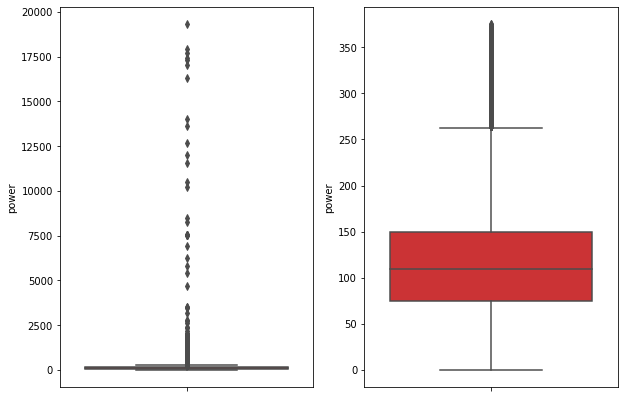

In [4]:
train = outliers_proc(train, 'power', scale = 3)

make new features

In [6]:
train['train'] = 1
test['train'] = 0
data = pd.concat([train, test], ignore_index = True, sort = False)
print(data.shape)

(199037, 32)


In [7]:
#define used_time
data['creatDate'] = pd.to_datetime(data['creatDate'], format = '%Y%m%d', errors = 'coerce')
data['regDate'] = pd.to_datetime(data['regDate'], format = '%Y%m%d', errors = 'coerce')
data['used_time'] = (data['creatDate'] - data['regDate']).dt.days


In [8]:
data['city'] = data['regionCode'].apply(lambda x : str(x)[:-3])

In [9]:
train_gb_df = train.groupby('brand')
 
all_info = {}
# groupby处理后的表格，遍历时有两个参数
# 第一个表示组别编号，第二个表示组别的具体表格
for kind, kind_data in train_gb_df:
    info = {}
    kind_data = kind_data[kind_data['price'] > 0]
    info['brand_amount'] = len(kind_data)
    info['brand_price_max'] = kind_data.price.max()
    info['brand_price_median'] = kind_data.price.median()
    info['brand_price_min'] = kind_data.price.min()
    info['brand_price_sum'] = kind_data.price.sum()
    info['brand_price_std'] = kind_data.price.std()
    # round()是以四舍五入的方式计算浮点数的值的函数
    info['brand_price_average'] = round(kind_data.price.sum() / \
                                        (len(kind_data) + 1), 2)
    all_info[kind] = info
brand_fe_df = pd.DataFrame(all_info).T.reset_index().rename(columns = \
                                                            {"index": "brand"})
data = data.merge(brand_fe_df, how = 'left', on = 'brand')


In [10]:
bin = [i * 10 for i in range(31)]
data['power_bin'] = pd.cut(data['power'], bin, labels = False)
data[['power_bin', 'power']].head()

,power_bin,power
0,5.0,60
1,NaN,0
2,16.0,163
3,19.0,193
4,6.0,68


delete original features

In [11]:
data = data.drop(['creatDate', 'regDate', 'regionCode'], axis=1)

In [12]:
data.to_csv('data_tree.csv', index = False)

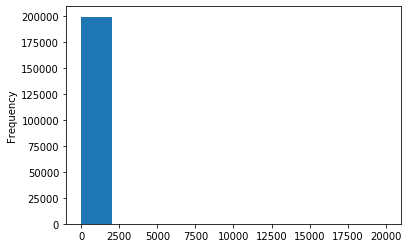

In [14]:
data['power'].plot.hist()

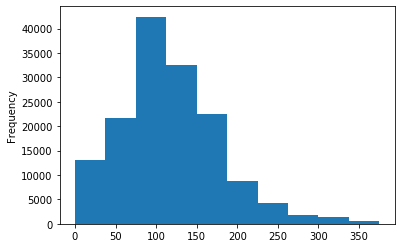

In [15]:
train['power'].plot.hist()

unifornization

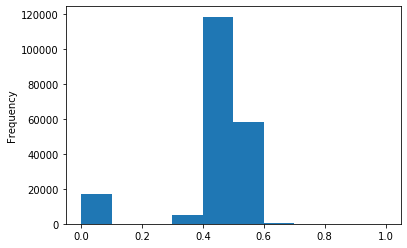

In [16]:
from sklearn.preprocessing import MinMaxScaler
 
min_max_scaler = MinMaxScaler()
# 我们对其取对数，再做归一化
data['power'] = np.log(data['power'] + 1) 
data['power'] = min_max_scaler.fit_transform(data['power'].values.reshape(-1, 1))
data['power'].plot.hist()

one-hot code

In [17]:
data = pd.get_dummies(data, columns = ['model', 'brand', 'bodyType', 'fuelType',
                                    'gearbox', 'notRepairedDamage', 'power_bin'])
print(data.shape)
data.columns

(199037, 370)


Index(['SaleID', 'name', 'power', 'kilometer', 'seller', 'offerType', 'price',
       'v_0', 'v_1', 'v_2',
       ...
       'power_bin_20.0', 'power_bin_21.0', 'power_bin_22.0', 'power_bin_23.0',
       'power_bin_24.0', 'power_bin_25.0', 'power_bin_26.0', 'power_bin_27.0',
       'power_bin_28.0', 'power_bin_29.0'],
      dtype='object', length=370)

select features-methods